In [ ]:
!pip install pyswarms shapely
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from decimal import Decimal, getcontext
import pyswarms as ps
from pyswarms.single import GlobalBestPSO
from scipy.optimize import minimize

getcontext().prec = 5

# **Helper Fcuntion Section**
This section is for the general preparation, calculation, and plotting functions needed for the optimization problem setup.

In [164]:
# GCODE TRANSLATION===============================================================================
def read_gcode_to_array(file_path):
    coordinates = []

    with open(file_path, 'r') as file:
        gcode_list = file.readlines()

    for command in gcode_list:
        parts = command.split()
        x_value = None
        y_value = None

        for part in parts:
            if part.startswith('X'):
                x_value = float(part[1:])
            elif part.startswith('Y'):
                y_value = float(part[1:])

        if x_value is not None and y_value is not None:
            coordinates.append((x_value, y_value))

    return np.array(coordinates)

def plot_polygon(coordinates):
    if coordinates.size == 0:
        print("No coordinates to plot.")
        return

    plt.figure()
    plt.plot(coordinates[:, 0], coordinates[:, 1], marker='')
    plt.fill(coordinates[:, 0], coordinates[:, 1], alpha=0.3)
    plt.title('Polygon from G-Code Coordinates')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim(45, 175)
    plt.ylim(35, 165)
    plt.show()
# GCODE TRANSLATION===============================================================================



# TWO INFILL PATTERNS=============================================================================
def xy_grid_pattern(center, increase_rate, grid_amount):
    lines = []
    distances = [0]

    for i in range(1, grid_amount + 1):
        distances.append(distances[-1] + increase_rate * i)

    boundary = max(distances) + increase_rate

    for distance in distances:
        vertical_line_pos = center[0] + distance
        vertical_line_neg = center[0] - distance
        lines.append(LineString([(vertical_line_pos, center[1] - boundary), (vertical_line_pos, center[1] + boundary)]))
        lines.append(LineString([(vertical_line_neg, center[1] - boundary), (vertical_line_neg, center[1] + boundary)]))

        horizontal_line_pos = center[1] + distance
        horizontal_line_neg = center[1] - distance
        lines.append(LineString([(center[0] - boundary, horizontal_line_pos), (center[0] + boundary, horizontal_line_pos)]))
        lines.append(LineString([(center[0] - boundary, horizontal_line_neg), (center[0] + boundary, horizontal_line_neg)]))

    return lines


def radial_grid_pattern(center, line_amount, line_length):
    lines = []
    angle_increment = 360.0 / line_amount

    for i in range(line_amount):
        angle = angle_increment * i
        angle_rad = np.radians(angle)

        end_x = float(center[0]) + float(line_length) * np.cos(angle_rad)
        end_y = float(center[1]) + float(line_length) * np.sin(angle_rad)

        lines.append(LineString([(float(center[0]), float(center[1])), (end_x, end_y)]))

    return lines
# TWO INFILL PATTERNS=============================================================================



# PLOT JUST INFILL PATTERNS=======================================================================
def plot_grid_pattern(center, grid_pattern_lines):
    for line in grid_pattern_lines:
        x, y = line.xy
        plt.plot(x, y, 'r', alpha=0.5)

    plt.scatter(*center, color='b', label="Center Point")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()
# PLOT JUST INFILL PATTERNS=======================================================================



# OBJ FUNCTION EVALUATION AND PLOT ===============================================================
def calculate_grid_length_inside_polygon(polygon_coords, lines):
    polygon = Polygon(polygon_coords)
    total_length = 0.0
    for line in lines:
        if polygon.intersects(line):
            intersection = polygon.intersection(line)
            total_length += float(intersection.length)
    return total_length

def plot_grid_pattern_in_polygon(center, polygon_coords, grid_pattern_lines):
    polygon = Polygon(polygon_coords)

    x, y = polygon.exterior.xy
    plt.plot(x, y, label="Polygon Boundary", color='black')

    for line in grid_pattern_lines:
        x, y = line.xy
        plt.plot(x, y, 'r--', alpha=0.5)

    for line in grid_pattern_lines:
        if polygon.intersects(line):
            intersection = polygon.intersection(line)
            if isinstance(intersection, LineString):
                x, y = intersection.xy
                plt.plot(x, y, 'g-')
            elif isinstance(intersection, MultiLineString):
                for geom in intersection.geoms:
                    x, y = geom.xy
                    plt.plot(x, y, 'g-')

    plt.scatter(*center, color='blue', label="Center Point")
    # plt.legend()
    plt.xlim(45, 175)
    plt.ylim(45, 175)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
# OBJ FUNCTION EVALUATION AND PLOT ===============================================================

# **FDM Selected Layer Boundary**
This can be read from .txt file, but we input the array directly here for easy collaboration in Google Colab.

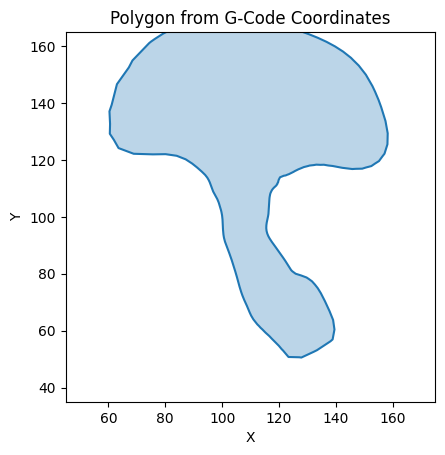

In [147]:
coordinates_array_mu = np.array([
[107.986000, 169.208000],
[109.462000, 169.084000],
[110.603000, 169.004000],
[112.577000, 168.741000],
[115.242000, 168.441000],
[115.665000, 168.378000],
[118.451000, 167.827000],
[119.983000, 167.544000],
[121.243000, 167.198000],
[123.806000, 166.547000],
[124.479000, 166.341000],
[127.399000, 165.390000],
[130.540000, 164.257000],
[133.664000, 162.996000],
[136.682000, 161.600000],
[139.646000, 160.007000],
[142.520000, 158.164000],
[143.668000, 157.274000],
[145.333000, 155.943000],
[146.099000, 155.161000],
[148.046000, 153.242000],
[150.388000, 150.251000],
[150.559000, 150.015000],
[152.862000, 146.019000],
[153.777000, 144.074000],
[155.029000, 141.118000],
[155.950000, 138.587000],
[157.108000, 134.918000],
[157.452000, 133.730000],
[157.695000, 132.348000],
[158.231000, 129.416000],
[158.140000, 125.541000],
[157.107000, 122.239000],
[156.434000, 121.375000],
[155.157000, 119.638000],
[153.783000, 118.774000],
[152.471000, 117.881000],
[150.552000, 117.375000],
[149.267000, 116.972000],
[147.092000, 116.924000],
[145.767000, 116.845000],
[143.796000, 117.095000],
[142.222000, 117.278000],
[140.314000, 117.621000],
[138.839000, 117.919000],
[137.285000, 118.095000],
[135.794000, 118.356000],
[134.586000, 118.317000],
[133.123000, 118.385000],
[132.216000, 118.231000],
[130.763000, 118.072000],
[130.114000, 117.877000],
[128.718000, 117.525000],
[128.333000, 117.362000],
[126.993000, 116.847000],
[126.778000, 116.725000],
[125.545000, 116.112000],
[125.090000, 115.839000],
[124.408000, 115.484000],
[124.275000, 115.436000],
[123.355000, 114.984000],
[122.999000, 114.880000],
[122.365000, 114.601000],
[121.617000, 114.471000],
[121.327000, 114.332000],
[120.367000, 113.954000],
[119.990000, 113.197000],
[119.897000, 113.055000],
[119.732000, 112.463000],
[119.716000, 112.251000],
[119.490000, 111.913000],
[119.457000, 111.634000],
[119.261000, 111.455000],
[119.117000, 111.118000],
[118.170000, 110.241000],
[117.789000, 109.813000],
[117.464000, 109.355000],
[117.324000, 109.080000],
[117.216000, 108.893000],
[117.016000, 108.414000],
[116.872000, 107.930000],
[116.770000, 107.443000],
[116.689000, 106.921000],
[116.632000, 106.396000],
[116.424000, 103.275000],
[116.328000, 101.488000],
[116.285000, 101.066000],
[116.151000, 100.239000],
[115.767000, 98.469000],
[115.682000, 98.007000],
[115.609000, 97.539000],
[115.556000, 97.076000],
[115.520000, 96.604000],
[115.516000, 96.086000],
[115.549000, 95.604000],
[115.616000, 95.120000],
[115.727000, 94.620000],
[115.860000, 94.162000],
[116.029000, 93.709000],
[116.242000, 93.240000],
[116.455000, 92.826000],
[116.711000, 92.392000],
[117.215000, 91.604000],
[117.477000, 91.222000],
[118.844000, 89.332000],
[120.410000, 87.086000],
[121.381000, 85.755000],
[121.779000, 85.194000],
[122.179000, 84.591000],
[123.948000, 81.748000],
[124.257000, 81.313000],
[124.669000, 80.886000],
[125.846000, 80.019000],
[127.790000, 79.406000],
[129.696000, 78.692000],
[130.533000, 78.131000],
[131.593000, 77.366000],
[132.646000, 76.195000],
[133.631000, 74.937000],
[134.701000, 73.201000],
[136.156000, 70.360000],
[137.780000, 66.844000],
[139.029000, 63.755000],
[139.505000, 60.393000],
[138.856000, 56.914000],
[138.094000, 56.252000],
[133.388000, 53.146000],
[132.209000, 52.561000],
[127.860000, 50.538000],
[127.131000, 50.635000],
[123.339000, 50.734000],
[121.405000, 53.023000],
[120.940000, 53.484000],
[119.926000, 54.698000],
[119.064000, 55.560000],
[118.688000, 55.960000],
[117.917000, 56.667000],
[117.603000, 57.041000],
[117.449000, 57.183000],
[116.593000, 58.095000],
[116.002000, 58.614000],
[115.699000, 58.920000],
[115.223000, 59.329000],
[114.885000, 59.690000],
[114.676000, 59.876000],
[114.138000, 60.441000],
[113.534000, 60.986000],
[112.880000, 61.712000],
[112.377000, 62.199000],
[111.870000, 62.829000],
[111.577000, 63.157000],
[111.447000, 63.342000],
[111.201000, 63.652000],
[110.988000, 63.954000],
[110.732000, 64.381000],
[110.549000, 64.655000],
[110.430000, 64.885000],
[110.197000, 65.287000],
[109.958000, 65.769000],
[109.680000, 66.396000],
[108.705000, 68.726000],
[108.318000, 69.548000],
[107.772000, 70.776000],
[107.398000, 71.663000],
[107.144000, 72.323000],
[106.712000, 73.510000],
[106.719000, 73.520000],
[106.408000, 74.492000],
[106.129000, 75.427000],
[105.356000, 78.271000],
[105.269000, 78.554000],
[105.176000, 78.921000],
[104.608000, 80.856000],
[103.791000, 83.494000],
[103.370000, 84.801000],
[102.933000, 86.077000],
[102.492000, 87.295000],
[102.014000, 88.559000],
[101.353000, 90.217000],
[101.004000, 91.279000],
[100.810000, 91.975000],
[100.644000, 92.662000],
[100.522000, 93.333000],
[100.459000, 93.773000],
[100.372000, 94.635000],
[100.296000, 95.585000],
[100.200000, 97.735000],
[100.125000, 99.138000],
[100.019000, 100.225000],
[99.965000, 100.596000],
[99.836000, 101.317000],
[99.759000, 101.687000],
[99.593000, 102.383000],
[99.195000, 103.777000],
[98.861000, 104.834000],
[98.745000, 105.169000],
[98.453000, 105.890000],
[98.274000, 106.272000],
[98.282000, 106.286000],
[97.917000, 106.942000],
[97.272000, 108.037000],
[97.057000, 108.451000],
[96.850000, 108.916000],
[96.692000, 109.337000],
[96.155000, 110.856000],
[95.926000, 111.460000],
[95.646000, 112.144000],
[95.306000, 112.889000],
[94.803000, 113.774000],
[94.016000, 114.788000],
[92.841000, 115.935000],
[91.153000, 117.417000],
[89.462000, 118.764000],
[87.151000, 120.271000],
[86.913000, 120.359000],
[84.147000, 121.491000],
[84.019000, 121.503000],
[80.094000, 122.076000],
[75.621000, 122.005000],
[70.356000, 122.140000],
[68.886000, 122.211000],
[65.112000, 123.657000],
[63.562000, 124.212000],
[61.911000, 127.116000],
[60.490000, 129.243000],
[60.576000, 132.706000],
[60.366000, 137.139000],
[61.150000, 139.454000],
[62.997000, 146.682000],
[67.190000, 152.583000],
[68.461000, 155.034000],
[71.061000, 157.755000],
[74.340000, 161.144000],
[74.993000, 161.672000],
[76.364000, 162.629000],
[79.256000, 164.486000],
[80.739000, 165.231000],
[83.474000, 166.469000],
[87.521000, 167.851000],
[87.786000, 167.916000],
[91.656000, 168.626000],
[94.442000, 169.017000],
[95.510000, 169.141000],
[97.061000, 169.300000],
[101.071000, 169.404000],
[104.501000, 169.407000],
[106.214000, 169.292000],
[107.986000, 169.208000]
])
plot_polygon(coordinates_array_mu)

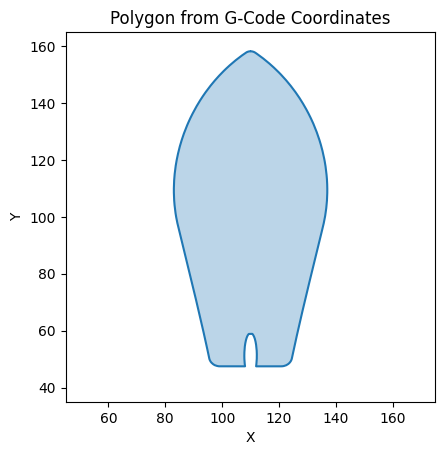

In [148]:
coordinates_array_bo = np.array([
[110.292000, 158.248000],
[110.654000, 158.188000],
[111.139000, 158.042000],
[111.588000, 157.804000],
[112.189000, 157.396000],
[113.532000, 156.423000],
[114.416000, 155.750000],
[115.724000, 154.697000],
[116.581000, 153.972000],
[117.422000, 153.231000],
[118.188000, 152.531000],
[119.000000, 151.764000],
[119.893000, 150.879000],
[120.698000, 150.050000],
[121.911000, 148.738000],
[122.488000, 148.073000],
[123.485000, 146.896000],
[124.106000, 146.120000],
[125.171000, 144.732000],
[125.801000, 143.871000],
[126.862000, 142.339000],
[127.188000, 141.850000],
[127.822000, 140.861000],
[128.436000, 139.857000],
[129.034000, 138.840000],
[129.610000, 137.813000],
[129.999000, 137.098000],
[130.437000, 136.249000],
[131.219000, 134.666000],
[132.076000, 132.796000],
[132.853000, 130.902000],
[133.268000, 129.811000],
[133.850000, 128.171000],
[134.201000, 127.100000],
[134.707000, 125.420000],
[135.106000, 123.959000],
[135.293000, 123.224000],
[135.672000, 121.581000],
[135.913000, 120.395000],
[136.071000, 119.557000],
[136.366000, 117.778000],
[136.572000, 116.198000],
[136.726000, 114.778000],
[136.852000, 113.326000],
[136.948000, 111.456000],
[136.984000, 109.901000],
[136.976000, 108.398000],
[136.927000, 106.925000],
[136.862000, 105.711000],
[136.727000, 104.087000],
[136.621000, 103.095000],
[136.420000, 101.542000],
[136.232000, 100.342000],
[136.050000, 99.335000],
[135.724000, 97.740000],
[135.000000, 94.703000],
[130.693000, 77.091000],
[128.249000, 66.865000],
[126.280000, 58.299000],
[124.487000, 50.071000],
[124.335000, 49.644000],
[124.140000, 49.260000],
[123.875000, 48.886000],
[123.564000, 48.540000],
[123.216000, 48.245000],
[122.817000, 47.985000],
[122.524000, 47.827000],
[122.164000, 47.690000],
[121.725000, 47.563000],
[121.330000, 47.487000],
[120.757000, 47.452000],
[111.944000, 47.448000],
[112.040000, 48.181000],
[112.148000, 49.454000],
[112.180000, 50.120000],
[112.196000, 50.980000],
[112.196000, 51.728000],
[112.152000, 52.966000],
[112.031000, 54.322000],
[111.942000, 55.015000],
[111.861000, 55.534000],
[111.755000, 56.090000],
[111.622000, 56.659000],
[111.498000, 57.127000],
[111.354000, 57.563000],
[111.205000, 57.935000],
[111.041000, 58.279000],
[110.856000, 58.578000],
[110.653000, 58.827000],
[110.536000, 58.876000],
[109.444000, 58.871000],
[109.349000, 58.840000],
[109.138000, 58.571000],
[108.963000, 58.291000],
[108.802000, 57.955000],
[108.650000, 57.576000],
[108.503000, 57.133000],
[108.377000, 56.670000],
[108.259000, 56.170000],
[108.146000, 55.584000],
[108.057000, 55.031000],
[107.976000, 54.431000],
[107.868000, 53.263000],
[107.824000, 52.415000],
[107.804000, 51.750000],
[107.800000, 51.112000],
[107.820000, 50.080000],
[107.880000, 49.006000],
[107.949000, 48.229000],
[108.055000, 47.452000],
[99.237000, 47.449000],
[98.889000, 47.460000],
[98.538000, 47.510000],
[98.276000, 47.563000],
[97.832000, 47.690000],
[97.472000, 47.827000],
[97.179000, 47.985000],
[96.781000, 48.245000],
[96.418000, 48.554000],
[96.201000, 48.778000],
[95.907000, 49.171000],
[95.618000, 49.729000],
[95.490000, 50.132000],
[94.748000, 53.628000],
[93.463000, 59.429000],
[92.279000, 64.590000],
[90.799000, 70.892000],
[84.556000, 96.529000],
[84.264000, 97.784000],
[84.073000, 98.692000],
[83.837000, 99.916000],
[83.606000, 101.330000],
[83.424000, 102.708000],
[83.268000, 104.112000],
[83.132000, 105.746000],
[83.048000, 107.508000],
[83.020000, 108.505000],
[83.016000, 110.045000],
[83.053000, 111.529000],
[83.121000, 112.879000],
[83.205000, 114.081000],
[83.310000, 115.182000],
[83.499000, 116.800000],
[83.671000, 118.036000],
[83.819000, 118.952000],
[84.016000, 120.041000],
[84.256000, 121.250000],
[84.472000, 122.226000],
[84.702000, 123.204000],
[85.110000, 124.793000],
[85.468000, 126.034000],
[85.807000, 127.127000],
[86.202000, 128.331000],
[86.552000, 129.331000],
[87.171000, 130.966000],
[87.659000, 132.160000],
[88.075000, 133.126000],
[88.809000, 134.730000],
[89.599000, 136.324000],
[90.476000, 137.979000],
[91.002000, 138.907000],
[91.600000, 139.920000],
[92.222000, 140.933000],
[93.179000, 142.404000],
[94.179000, 143.851000],
[95.224000, 145.263000],
[95.941000, 146.183000],
[96.675000, 147.092000],
[97.424000, 147.973000],
[98.166000, 148.822000],
[98.941000, 149.668000],
[99.756000, 150.524000],
[100.561000, 151.337000],
[101.386000, 152.138000],
[102.630000, 153.286000],
[103.914000, 154.399000],
[104.770000, 155.108000],
[106.189000, 156.220000],
[107.015000, 156.825000],
[108.344000, 157.767000],
[108.591000, 157.909000],
[108.951000, 158.068000],
[109.342000, 158.188000],
[109.805000, 158.263000],
])
plot_polygon(coordinates_array_bo)

In [154]:
coordinates_array = coordinates_array_bo

# **Test the General Functions**
This section gives an initial screening on the previous listed helper functions with the layer info above. You can visualize the actuall computation here.

Total Length Inside Polygon (XY Grid): 1225.9448114389143


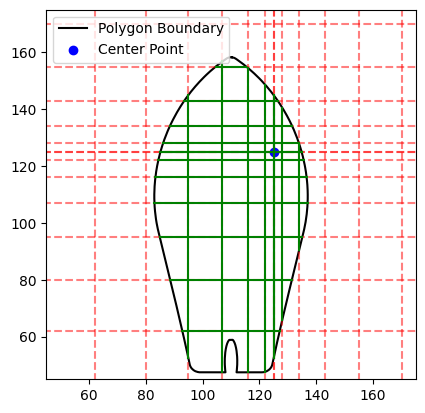

Total Length Inside Polygon (Radial Grid): 1271.8757846167841


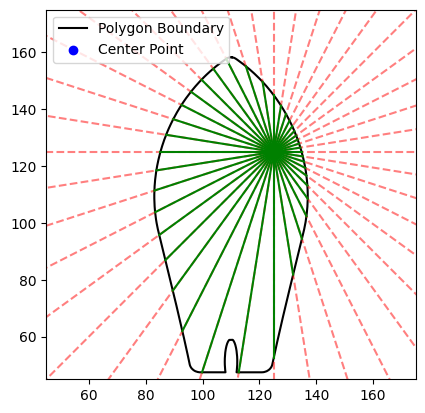

In [155]:
# Example usage for xy grid pattern:
ini_center = (125, 125)
increase_rate = 3
grid_amount = 10

xy_pattern_details = xy_grid_pattern(ini_center, increase_rate, grid_amount)
total_length_inside_xy = calculate_grid_length_inside_polygon(coordinates_array, xy_pattern_details)
print("Total Length Inside Polygon (XY Grid):", total_length_inside_xy)
plot_grid_pattern_in_polygon(ini_center, coordinates_array, xy_pattern_details)

# Example usage for radial grid pattern:
line_amount = 40
line_length = 200

radial_pattern_details = radial_grid_pattern(ini_center, line_amount, line_length)
total_length_inside_radial = calculate_grid_length_inside_polygon(coordinates_array, radial_pattern_details)
print("Total Length Inside Polygon (Radial Grid):", total_length_inside_radial)
plot_grid_pattern_in_polygon(ini_center, coordinates_array, radial_pattern_details)

# **Optimization Setup: Infill Pattern Geometry Parameters**
In this section you setup the RDG infill pattern that is used for the offical optimization process.

In [160]:
# just for optimization settings

pattern_type = 'radial'
initial_points = [(100, 50), (110, 155), (130, 110)]

# initial_points = [(130, 60), (150, 120), (80, 150)]

# xy:
increase_rate = 3
grid_amount = 10

# radial:
line_amount = 40
line_length = 200

# **Optimization Setup: Objective Functions**


In [157]:
def objective_function(new_x):
    if pattern_type == 'xy':
        pattern_lines = xy_grid_pattern(new_x, increase_rate, grid_amount)
    elif pattern_type == 'radial':
        pattern_lines = radial_grid_pattern(new_x, line_amount, line_length)

    return calculate_grid_length_inside_polygon(coordinates_array, pattern_lines)

def objective_function_neg(new_x):
    if pattern_type == 'xy':
        pattern_lines = xy_grid_pattern(new_x, increase_rate, grid_amount)
    elif pattern_type == 'radial':
        pattern_lines = radial_grid_pattern(new_x, line_amount, line_length)

    return -calculate_grid_length_inside_polygon(coordinates_array, pattern_lines)

# **Optimizer: Simulated Annealing and Corresponding Plots**

In [ ]:
def simulated_annealing(f, x, T, t, k_max, tol=0.5e-2):
    y = f(x)
    x_best, y_best = x, y

    x_history = [x]
    f_history = [y]

    for k in range(k_max):
        # Generate a new candidate solution
        x_prime = (x[0] + (np.random.rand() - 0.5), x[1] + (np.random.rand() - 0.5))
        y_prime = f(x_prime)
        Δy = y_prime - y

        # Record the current state before any updates
        x_history.append(x)
        f_history.append(y)

        # Ensure all calculations are performed with float
        if Δy >= 0 or np.random.rand() < np.exp(float(Δy) / float(t[min(k, len(t) - 1)])):
            x, y = x_prime, y_prime

        # Update the best solution found so far
        if y_prime > y_best:
            x_best, y_best = x_prime, y_prime

        # Break the loop if the change in function value is below the tolerance
        if abs(Δy) < tol:
            print(f"Converged after {k + 1} iterations.")
            break

    return x_best, x_history, f_history


k_max = 5000

# Top plots, 3 initiations====================================
T = 1.0
alpha = 0.95
t = [T * alpha ** i for i in range(k_max)]

optimized_centers_1 = []
x_histories_1 = []
f_histories_1 = []

for ini_center in initial_points:
    optimized_center, x_history, f_history= simulated_annealing(objective_function, ini_center, T, t, k_max)
    optimized_centers_1.append(optimized_center)
    x_histories_1.append(x_history)
    f_histories_1.append(f_history)
    print("Optimized Center Point for initial center", ini_center, ":", optimized_center)
# Top plots, 3 initiations====================================


# Bot plots, 3 initiations====================================
T = 10.0
alpha = 0.99
t = [T * alpha ** i for i in range(k_max)]

optimized_centers_2 = []
x_histories_2 = []
f_histories_2 = []

for ini_center in initial_points:
    optimized_center, x_history, f_history= simulated_annealing(objective_function, ini_center, T, t, k_max)
    optimized_centers_2.append(optimized_center)
    x_histories_2.append(x_history)
    f_histories_2.append(f_history)
    print("Optimized Center Point for initial center", ini_center, ":", optimized_center)
# Bot plots, 3 initiations====================================

Converged after 630 iterations.
Optimized Center Point for initial center (100, 50) : (107.69472679742374, 100.51232438953213)
Converged after 344 iterations.
Optimized Center Point for initial center (110, 155) : (107.04222151593311, 116.24447466675295)
Converged after 64 iterations.
Optimized Center Point for initial center (130, 110) : (122.8850989338818, 110.04447897446231)
Converged after 562 iterations.
Optimized Center Point for initial center (100, 50) : (112.21622716019444, 103.08466756705863)
Converged after 484 iterations.
Optimized Center Point for initial center (110, 155) : (107.79952032546356, 107.81996419611745)
Converged after 314 iterations.
Optimized Center Point for initial center (130, 110) : (112.30586866662948, 105.18874904301842)


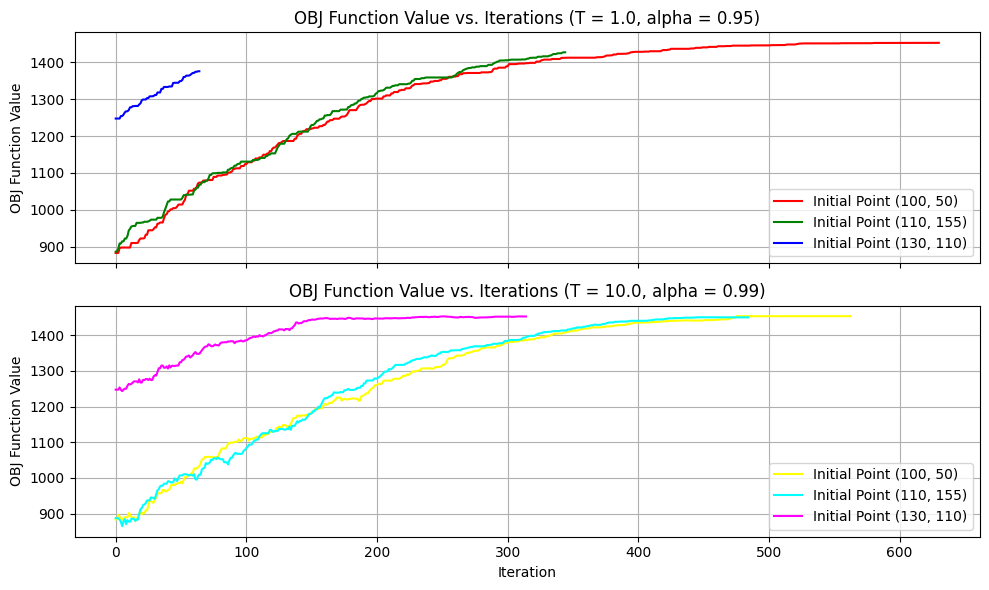

2024-06-02 00:27:28,671 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


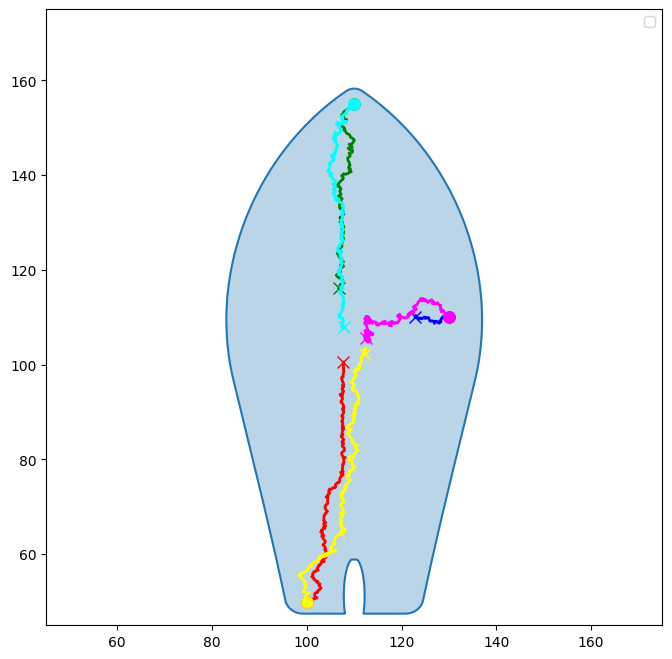

In [ ]:
colors_1 = ['red', 'green', 'blue']
colors_2 = ['yellow', 'cyan', 'magenta']

def combined_obj_and_delta_y_plot(f_histories_1, f_histories_2, initial_points, colors_1, colors_2):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    for i, (f_history_1, f_history_2, ini_point, color_1, color_2) in enumerate(zip(f_histories_1, f_histories_2, initial_points, colors_1, colors_2)):
        label = f'Initial Point {ini_point}'
        ax1.plot(f_history_1, marker='', color=color_1, label=label)
        ax2.plot(f_history_2, marker='', color=color_2, label=label)

    ax1.set_title('OBJ Function Value vs. Iterations (T = 1.0, alpha = 0.95)')
    ax1.set_ylabel('OBJ Function Value')
    ax1.grid(True)
    ax1.legend()

    ax2.set_title('OBJ Function Value vs. Iterations (T = 10.0, alpha = 0.99)')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('OBJ Function Value')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

combined_obj_and_delta_y_plot(f_histories_1, f_histories_2, initial_points, colors_1, colors_2)

def plot_polygon_with_x_history(coordinates, x_histories_1, x_histories_2, initial_points, colors_1, colors_2):
    if coordinates.size == 0:
        print("No coordinates to plot.")
        return

    plt.figure(figsize=(8, 8))
    plt.plot(coordinates[:, 0], coordinates[:, 1], marker='')
    plt.fill(coordinates[:, 0], coordinates[:, 1], alpha=0.3)
    plt.gca().set_aspect('equal', adjustable='box')

    for i, (x_history_1, x_history_2, ini_point, color_1, color_2) in enumerate(zip(x_histories_1, x_histories_2, initial_points, colors_1, colors_2)):
        x_history_1 = np.array(x_history_1)
        x_history_2 = np.array(x_history_2)

        plt.plot(x_history_1[:, 0], x_history_1[:, 1], marker='', linestyle='-', linewidth=2, color=color_1)
        plt.plot(x_history_1[0, 0], x_history_1[0, 1], marker='o', markersize=8, color=color_1)
        plt.plot(x_history_1[-1, 0], x_history_1[-1, 1], marker='x', markersize=8, color=color_1)

        plt.plot(x_history_2[:, 0], x_history_2[:, 1], marker='', linestyle='-', linewidth=2, color=color_2)
        plt.plot(x_history_2[0, 0], x_history_2[0, 1], marker='o', markersize=8, color=color_2)
        plt.plot(x_history_2[-1, 0], x_history_2[-1, 1], marker='x', markersize=8, color=color_2)

    plt.legend()
    plt.xlim(45, 175)
    plt.ylim(45, 175)
    plt.show()

plot_polygon_with_x_history(coordinates_array, x_histories_1, x_histories_2, initial_points, colors_1, colors_2)

# **Optimizer: Particle Swarm and Corresponding Plots**

In [161]:
class CustomGlobalBestPSO(GlobalBestPSO):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_costs = []
        self.best_positions = []

    def optimize(self, objective_func, iters, **kwargs):
        self.swarm.current_cost = np.full(self.swarm.n_particles, np.inf)
        self.swarm.pbest_cost = np.full(self.swarm.n_particles, np.inf)

        for i in range(iters):
            self.swarm.current_cost = objective_func(self.swarm.position)
            for j in range(self.swarm.n_particles):
                if self.swarm.current_cost[j] < self.swarm.pbest_cost[j]:
                    self.swarm.pbest_cost[j] = self.swarm.current_cost[j]
                    self.swarm.pbest_pos[j] = self.swarm.position[j].copy()

            if np.min(self.swarm.current_cost) < self.swarm.best_cost:
                self.swarm.best_cost = np.min(self.swarm.current_cost)
                self.swarm.best_pos = self.swarm.position[np.argmin(self.swarm.current_cost)].copy()

            self.best_costs.append(self.swarm.best_cost)
            self.best_positions.append(tuple(self.swarm.best_pos))

            self.swarm.velocity = (self.options['w'] * self.swarm.velocity
                                   + self.options['c1'] * np.random.uniform(0, 1, (self.swarm.n_particles, self.swarm.dimensions)) *
                                   (self.swarm.pbest_pos - self.swarm.position)
                                   + self.options['c2'] * np.random.uniform(0, 1, (self.swarm.n_particles, self.swarm.dimensions)) *
                                   (self.swarm.best_pos - self.swarm.position))
            self.swarm.position = self.swarm.position + self.swarm.velocity

        return self.swarm.best_cost, self.swarm.best_pos

def pso_with_polygon_constraints(objective_function, polygon_coords, swarmsize, maxiter):
    # Define the polygon from the coordinates
    polygon = Polygon(polygon_coords)

    # Define the constraint function to ensure the solution is inside the polygon
    def constraint(x):
        return np.array([polygon.contains(Point(xi)) for xi in x])

    # Define the wrapper to handle the constraint
    def constrained_objective_function(x):
        mask = constraint(x)
        constrained_values = np.where(mask, [objective_function(tuple(xi)) for xi in x], np.inf)
        return constrained_values

    # Extract bounds from polygon_coords
    lb = np.min(polygon_coords, axis=0)
    ub = np.max(polygon_coords, axis=0)

    # Initializing the custom optimizer
    optimizer = CustomGlobalBestPSO(n_particles=swarmsize, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=(lb, ub))
    cost, pos = optimizer.optimize(constrained_objective_function, iters=maxiter)

    return pos, cost, optimizer.best_costs, optimizer.best_positions


def run_pso_multiple_times(objective_function, polygon_coords, swarmsize, maxiter, runs=3):
    optimized_positions = []
    x_histories = []
    f_histories = []

    for run in range(runs):
        np.random.seed(run)
        best_position, best_cost, best_costs, best_positions = pso_with_polygon_constraints(objective_function, polygon_coords, swarmsize, maxiter)
        optimized_positions.append(best_position)
        x_histories.append(best_positions)
        f_histories.append(best_costs)
        print(f"Run {run + 1}: Best Position = {best_position}, Best Cost = {best_cost}")

    return optimized_positions, x_histories, f_histories

# Top plots, 3 initiations
optimized_positions, x_histories_1, f_histories_1 = run_pso_multiple_times(objective_function_neg, coordinates_array, swarmsize=3, maxiter=50)
# Bot plots, 3 initiations
optimized_positions, x_histories_2, f_histories_2 = run_pso_multiple_times(objective_function_neg, coordinates_array, swarmsize=10, maxiter=50)

Run 1: Best Position = [112.24274751 103.16119288], Best Cost = -1453.5283755024225
Run 2: Best Position = [107.78195682 102.76365743], Best Cost = -1453.5385173345378
Run 3: Best Position = [112.30241376 103.83897588], Best Cost = -1453.373463756784
Run 1: Best Position = [107.78581699 103.44100365], Best Cost = -1453.55115478504
Run 2: Best Position = [112.19890706 102.84693597], Best Cost = -1453.5716477127748
Run 3: Best Position = [112.23429304 103.01259041], Best Cost = -1453.5381140073735


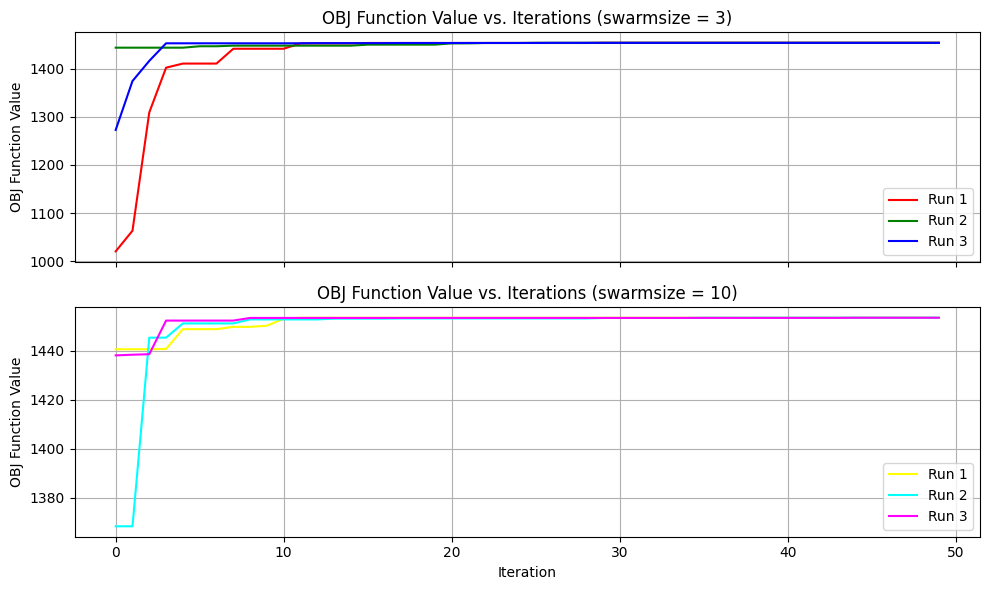

2024-06-02 01:16:14,896 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


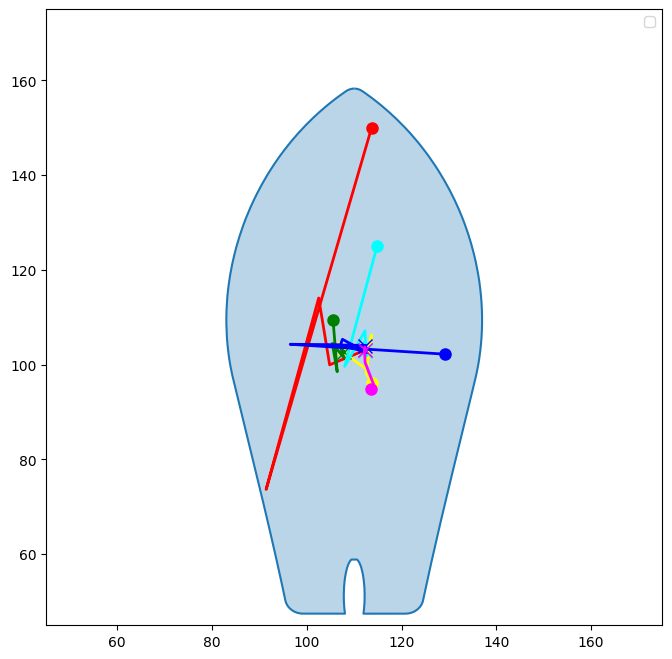

In [163]:
colors_1 = ['red', 'green', 'blue']
colors_2 = ['yellow', 'cyan', 'magenta']

def combined_obj_and_delta_y_plot(f_histories_1, f_histories_2, colors_1, colors_2):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    for i, (f_history_1, f_history_2, color_1, color_2) in enumerate(zip(f_histories_1, f_histories_2, colors_1, colors_2)):
        label_1 = f'Run {i+1}'
        label_2 = f'Run {i+1}'
        neg_f_history_1 = [-f for f in f_history_1] # transfer back from negative obj function
        neg_f_history_2 = [-f for f in f_history_2]
        ax1.plot(neg_f_history_1, marker='', color=color_1, label=label_1)
        ax2.plot(neg_f_history_2, marker='', color=color_2, label=label_2)

    ax1.set_title('OBJ Function Value vs. Iterations (swarmsize = 3)')
    ax1.set_ylabel('OBJ Function Value')
    ax1.grid(True)
    ax1.legend()

    ax2.set_title('OBJ Function Value vs. Iterations (swarmsize = 10)')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('OBJ Function Value')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

combined_obj_and_delta_y_plot(f_histories_1, f_histories_2, colors_1, colors_2)



def plot_polygon_with_x_history(coordinates, x_histories_1, x_histories_2, colors_1, colors_2):
    if coordinates.size == 0:
        print("No coordinates to plot.")
        return

    plt.figure(figsize=(8, 8))
    plt.plot(coordinates[:, 0], coordinates[:, 1], marker='')
    plt.fill(coordinates[:, 0], coordinates[:, 1], alpha=0.3)
    plt.gca().set_aspect('equal', adjustable='box')

    for i, (x_history_1, x_history_2, color_1, color_2) in enumerate(zip(x_histories_1, x_histories_2, colors_1, colors_2)):
        x_history_1 = np.array(x_history_1)
        x_history_2 = np.array(x_history_2)

        plt.plot(x_history_1[:, 0], x_history_1[:, 1], marker='', linestyle='-', linewidth=2, color=color_1)
        plt.plot(x_history_1[0, 0], x_history_1[0, 1], marker='o', markersize=8, color=color_1)
        plt.plot(x_history_1[-1, 0], x_history_1[-1, 1], marker='x', markersize=10, color=color_1)

        plt.plot(x_history_2[:, 0], x_history_2[:, 1], marker='', linestyle='-', linewidth=2, color=color_2)
        plt.plot(x_history_2[0, 0], x_history_2[0, 1], marker='o', markersize=8, color=color_2)
        plt.plot(x_history_2[-1, 0], x_history_2[-1, 1], marker='x', markersize=10, color=color_2)

    plt.legend()
    plt.xlim(45, 175)
    plt.ylim(45, 175)
    plt.show()

plot_polygon_with_x_history(coordinates_array, x_histories_1, x_histories_2, colors_1, colors_2)

# **Final Demo by PSO Results**

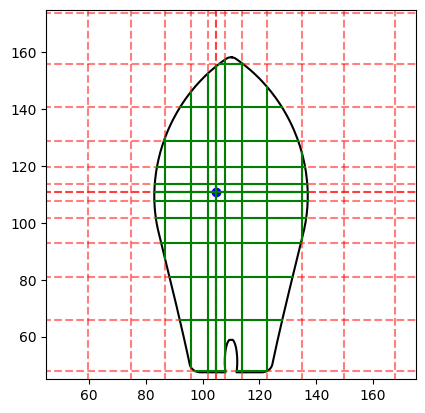

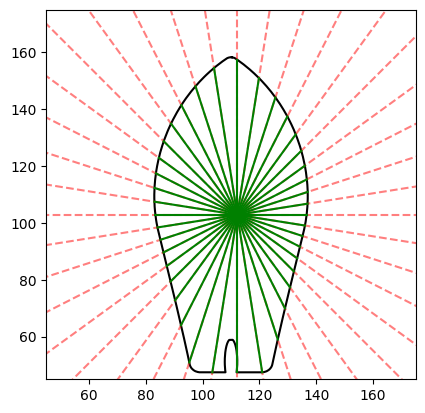

In [165]:
coordinates_array = coordinates_array_bo

center1 = (104.79915262, 110.82644286)
xy_pattern_details = xy_grid_pattern(center1, increase_rate, grid_amount)
plot_grid_pattern_in_polygon(center1, coordinates_array, xy_pattern_details)

center2 = (112.19890706, 102.84693597)
radial_pattern_details = radial_grid_pattern(center2, line_amount, line_length)
plot_grid_pattern_in_polygon(center2, coordinates_array, radial_pattern_details)

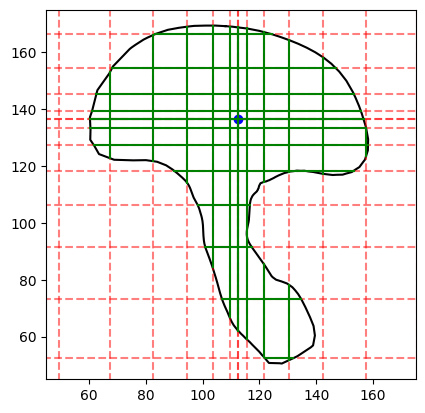

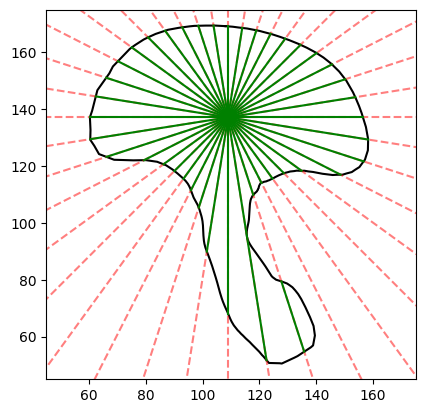

In [166]:
coordinates_array = coordinates_array_mu

center3 = (112.51201677, 136.38308305)
xy_pattern_details = xy_grid_pattern(center3, increase_rate, grid_amount)
plot_grid_pattern_in_polygon(center3, coordinates_array, xy_pattern_details)

center4 = (108.96021733, 137.1284218)
radial_pattern_details = radial_grid_pattern(center4, line_amount, line_length)
plot_grid_pattern_in_polygon(center4, coordinates_array, radial_pattern_details)